# **Brocket to the Moon**

Be inspired.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

2023-05-17 14:08:35.090290: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [3]:
# Mount the Drive
path=[]
LOCAL = True
if LOCAL:
    path = './content/'
else:    
    from google.colab import drive
    drive.mount('/content/drive')
    path='/content/drive/MyDrive/Colab Notebooks/content/'

# **EDA**

The dateset is comprised of two files with comma seperated values.  These sets are presumed to intersect by dates.  A correlating index was not provided so we'll need to find a common intersection between these files.

<pre><font color="#12488B"><b>content/</b></font>
├── Assessments_vs_Sales.csv
└── data_homes.csv
</pre>

**Assessments_vs_Sales.csv**: Provides the sale-price and market-valuation for a subset the inspected properties.

**data_homes.csv**: Contains assements preformed by the City of Saturn inspectors.






In [4]:
df0 = pd.read_csv(f'{path}/data_homes.csv')
df1 = pd.read_csv(f'{path}/Assessments_vs_Sales.csv')

/tmp/ipykernel_1826/200317421.py:1: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  df0 = pd.read_csv(f'{path}/data_homes.csv')


In [5]:
df0[['PRINT_KEY','SALE_DATE', 'SALE_PRICE_LOG10']].head() # ...amongt many others from the City Inspector's notes.

,PRINT_KEY,SALE_DATE,SALE_PRICE_LOG10
0,002.-05-19.0,2016-12-13 11:24:06,4.750555
1,002.-06-09.0,2005-07-29 00:00:00,4.785330
2,002.-06-09.0,2015-05-14 10:38:15,4.740363
3,002.-06-10.0,2006-01-23 00:00:00,4.653213
4,002.-06-12.0,2007-01-10 00:00:00,4.826075


In [6]:
df1.head()

,PRINT_KEY,SALE_DATE,SALE_PRICE,MARKET_VAL
0,027.-21-01.0,2008-01-02 00:00:00,104750.0,78846.153846
1,027.-21-49.0,2008-01-03 00:00:00,55000.0,64102.564103
2,016.-07-14.0,2008-01-03 00:00:00,18000.0,38461.538462
3,014.-12-29.0,2008-01-04 00:00:00,155000.0,166666.666667
4,109.-08-24.0,2008-01-04 00:00:00,39500.0,25641.025641


# **Correlate an Index**

The **Assessment Department** has selected a number of inspections done by the **Inspections Department** to explore.  We don't have a single unique index to correlate the data from these two departments so we'll try using a some common columns to match them.

Let's try not to add any bias into the data in the process.

In [7]:
# Vesbose dataFrame format

#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [8]:
# Show that our datasets are not the same length
len(df0), len(df1)

(14471, 7201)

In [9]:
# Try using PRINT_KEY as index
df0_key = pd.DataFrame(df0.PRINT_KEY)
df1_key = pd.DataFrame(df1.PRINT_KEY)
#df_key.columns
df_key = pd.merge(df0_key, df1_key, on='PRINT_KEY', how='inner')
len(df0_key), len(df1_key), len(df_key), len(df1_key) == len(df_key) # not good 

(14471, 7201, 10540, False)

In [10]:
# Try using SALE_DATE as index
my_date = (df1.SALE_DATE).to_list()
df_dates = df0.loc[df0['SALE_DATE'].isin(my_date)] # this might be better
len(df_dates) # count is fine but let's...

7135

In [11]:
# ...see which ones are missing!
len(df1.loc[~df0['SALE_DATE'].isin(my_date)]) # '~' negate the logic, thus rows not-in our list 
# date are duplicated, but this is expected

3701

In [12]:
# Now try using SALE_PRICE_LOG10 and SALE_PRICE as index
my_sale = (df1.SALE_PRICE).to_numpy()
your_sale = my_sale
my_sale = np.log10(my_sale) #.round(1)

df0_sale = df0.loc[df0['SALE_PRICE_LOG10'].isin(my_sale)] # naive
len(df0_sale) # nope, too many dups

12509

In [13]:
df1_sale = df1.loc[df1['SALE_PRICE'].isin(your_sale)] # naive
len(df1_sale) # nice that these are unquie in this dataset

7201

In [14]:
df0_sale[['PRINT_KEY','SALE_DATE', 'SALE_PRICE_LOG10']].head()

,PRINT_KEY,SALE_DATE,SALE_PRICE_LOG10
0,002.-05-19.0,2016-12-13 11:24:06,4.750555
1,002.-06-09.0,2005-07-29 00:00:00,4.785330
2,002.-06-09.0,2015-05-14 10:38:15,4.740363
3,002.-06-10.0,2006-01-23 00:00:00,4.653213
4,002.-06-12.0,2007-01-10 00:00:00,4.826075


In [15]:
df1_sale[['PRINT_KEY', 'SALE_DATE', 'SALE_PRICE']].head()

,PRINT_KEY,SALE_DATE,SALE_PRICE
0,027.-21-01.0,2008-01-02 00:00:00,104750.0
1,027.-21-49.0,2008-01-03 00:00:00,55000.0
2,016.-07-14.0,2008-01-03 00:00:00,18000.0
3,014.-12-29.0,2008-01-04 00:00:00,155000.0
4,109.-08-24.0,2008-01-04 00:00:00,39500.0


In [16]:
str(round(10**df0['SALE_PRICE_LOG10'][100]))

'58500'

In [17]:
rnd = lambda x: round(10**x)
df0['SALE_PRICE_LOG10'].apply(rnd)

0        56306
1        61000
2        55000
3        45000
4        67000
         ...  
14466    63000
14467    74900
14468    45000
14469    58900
14470    65500
Name: SALE_PRICE_LOG10, Length: 14471, dtype: int64

In [18]:
# Okay 'index' was a poor name choice here but this is fine for now 
df0['index'] = df0.PRINT_KEY+df0.SALE_DATE + df0['SALE_PRICE_LOG10'].apply(lambda x: round(10**x)).astype(str)
df1['index'] = df1.PRINT_KEY+df1.SALE_DATE + (df1['SALE_PRICE']).apply(lambda x: round(x)).astype(str)
# looks like these are truly duplicate records so we can drop them
# also now that we know there are dups in the inspection records we ought 
# to be looking into that too.

In [19]:
# Now try using our new index
my_index = (df1['index']).to_list()  # or .to_list(), doesn't matter
df0_indexed = df0.loc[df0['index'].isin(my_index)] # naive
len(df0_indexed) # These are unique so that's (based on neg count diff below)

7119

In [20]:
len(df0) - len(df0.loc[~df0['index'].isin(my_index)] ) # neg count diff

7119

In [21]:
# Which indexes are not represented in the assessment selection?
my_index = df0_indexed['index'].to_list()
len(df1.loc[df1['index'].isin(my_index)])

7109

In [22]:
len(df1) - len(df1.loc[df1['index'].isin(my_index)]) # 92 records are missing

92

In [23]:
df1.loc[~df1['index'].isin(my_index)][['SALE_PRICE']].sum() #  $40 Million

SALE_PRICE    39897327.0
dtype: float64

In [24]:
# welp... that got complicated.
# anyway here are the requested assessments not in the inspector's records
df1.loc[~df1['index'].isin(my_index)][['PRINT_KEY','SALE_DATE', 'SALE_PRICE']] #.head()

# uhm... something up with this key-date combo

# if we have extra time then let's try...
# truncating the PRINT_KEY and SALE_DATE then cancatenating
# with str(round(SALE_PRICE)) or str(round(10**SALE_PRICE_LOG10)) 

# we are going to run with this for now...
# however missing property inspections records are a subject for further investigation.

,PRINT_KEY,SALE_DATE,SALE_PRICE
2,016.-07-14.0,2008-01-03 00:00:00,18000.0
15,003.-16-18.1,2008-01-11 00:00:00,53000.0
29,011.-08-27.0,2008-01-18 00:00:00,30000.0
37,002.-21-16.0,2008-01-22 00:00:00,75400.0
41,083.-13-23.0,2008-01-24 00:00:00,30000.0
...,...,...,...
6706,101.-05-14.3/16,2018-09-05 09:26:49,145000.0
6937,059.-07-44.0,2018-11-20 09:44:17,264825.0
7107,088.-20-11.0,2019-02-08 10:46:00,115000.0
7135,101.-05-14.3/12,2019-02-27 10:54:29,139900.0


In [25]:
df1.head()

,PRINT_KEY,SALE_DATE,SALE_PRICE,MARKET_VAL,index
0,027.-21-01.0,2008-01-02 00:00:00,104750.0,78846.153846,027.-21-01.02008-01-02 00:00:00104750
1,027.-21-49.0,2008-01-03 00:00:00,55000.0,64102.564103,027.-21-49.02008-01-03 00:00:0055000
2,016.-07-14.0,2008-01-03 00:00:00,18000.0,38461.538462,016.-07-14.02008-01-03 00:00:0018000
3,014.-12-29.0,2008-01-04 00:00:00,155000.0,166666.666667,014.-12-29.02008-01-04 00:00:00155000
4,109.-08-24.0,2008-01-04 00:00:00,39500.0,25641.025641,109.-08-24.02008-01-04 00:00:0039500


In [26]:
df0.PRINT_KEY.head()

0    002.-05-19.0
1    002.-06-09.0
2    002.-06-09.0
3    002.-06-10.0
4    002.-06-12.0
Name: PRINT_KEY, dtype: object

In [27]:
def report_unquie(df, missing = False):
    for col in list(df.columns):

        print(f'{col}: {len(df[col].unique())} (Missing: {df[col].isnull().sum()})')
        if (len(df[col].unique()) <=7):
          print(f'\t{df[col].unique()}')

def report_missing(df):
    for col in list(df.columns):
        if (df[col].isnull().sum()!=0):
          print(f'{col}: {len(df[col].unique())} (Missing: {df[col].isnull().sum()})')
          if (len(df[col].unique()) <=7):
            print(f'\t{df[col].unique()}')

In [28]:
def get_cats(df):
  cats = []
  for col in list(df.columns):
    if (len(df[col].unique()) <=7):
      cats.append(col)
  return cats # meow

In [29]:
# used for visualization
def drop_if_hot(df):
    for col in list(df.columns):
        if (len(df[col].unique()) <=2):
          #print(f'\t{df[col].unique()}')
          #print(col)
          df.drop(col, axis=1, inplace=True, errors='ingore')

# **Impute the data**

We shall drop columns with a large number of missing values, then impute the other to mean, mode or min.  

 We ought to be careful that our choices aren't a source of bias.  Our choices here are based on an informed understanding of the hypothesis space.  The data scientist desires to optimize model accuracy and reduce errors.  How might this result in model bias?

In [30]:
# Remove duplicates
df = df0.copy()
#unique_index = df['index'].unique().tolist()
#len(unique_index)
i = df[df.duplicated(subset=['index'])].index
#i = df[df.duplicated(subset=['index'])]['index']
#df.loc[df['index'].isin(i)][['index', 'SALE_PRICE_LOG10', 'YR_BUILT']]
#df1[df1.duplicated(subset=['index'])] #no dups
#df.loc[df['index'].isin(i)].index
df.drop(i, inplace=True)

In [31]:
df0.drop(i, inplace=True)
len(df) , len(df0)

(14461, 14461)

In [32]:
# save off a copy for the asssement exploration
df = df0.copy()

def clean_df(df):
  df0 = df.copy()

  # DROP List
  drop_list = ['issue_date', 'valuation', 'USED_AS_CD', 'TOTAL_RENT_AREA', 'PRINT_KEY', 'SALE_DATE', 'index']
  df0.drop(columns=drop_list, axis=1, inplace=True, errors='ingore')

  # IMPUTE 
  df0['WalkIndex'].fillna(float(df0['WalkIndex'].mode()), inplace = True)
  df0['buildings_300m'].fillna(float(df0['buildings_300m'].mode()), inplace = True)
  df0['FRONT_LOG10'].fillna(float(df0['FRONT_LOG10'].min()), inplace = True)
  df0['DEPTH_LOG10'].fillna(float(df0['DEPTH_LOG10'].min()), inplace = True)
  df0['AREA_PARCEL_RECT_LOG10'].fillna(float(df0['AREA_PARCEL_RECT_LOG10'].min()), inplace = True)
  report_missing(df0)
  return df0
df0 = clean_df(df0)

/tmp/ipykernel_1826/3798269944.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  df0['WalkIndex'].fillna(float(df0['WalkIndex'].mode()), inplace = True)
/tmp/ipykernel_1826/3798269944.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  df0['buildings_300m'].fillna(float(df0['buildings_300m'].mode()), inplace = True)


In [33]:
# No Strings attached
#PRINT_KEY, SALE_DATE
#df0.PRINT_KEY # ie '111.-16-15.0'
#df0.SALE_DATE # ie '2004-08-25 00:00:00'

# **Data Prep**

Get the data ready for the model.

In [34]:
#df0.describe()

In [35]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14461 entries, 0 to 14470
Columns: 139 entries, NBR_KITCHENS to SALE_PRICE_LOG10
dtypes: float64(31), int64(108)
memory usage: 15.4 MB


In [36]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
def imputer(df):
  # ''' This is meant as a exploratory tool.'''
  # Drop
  y=[]
  y = df.SALE_PRICE_LOG10.to_numpy()

  df_ = df.copy()
  df_.drop(columns=['SALE_PRICE_LOG10'], inplace=True, errors='ignore')

  # Let's drop all feature with two classes to made visulaization easiler.
  drop_if_hot(df_)

  # Scale
  scaler = MinMaxScaler(feature_range=(0,1)) 
  std_scaler = StandardScaler()
  df_scaled = df_.to_numpy()

  df_scaled = scaler.fit_transform(df_scaled)
  df_scaled = pd.DataFrame(df_scaled, columns=df_.columns.tolist())

  X = df_scaled.to_numpy()
  X.shape
  return X, y, df_scaled

In [37]:
def prepare(df):
  # Drop
  y = df.SALE_PRICE_LOG10.to_numpy()

  df_ = df.copy()
  df_.drop(columns=['SALE_PRICE_LOG10'], inplace=True, errors='ignore')
  
  X = df_.to_numpy()
  return X, y

<Axes: >

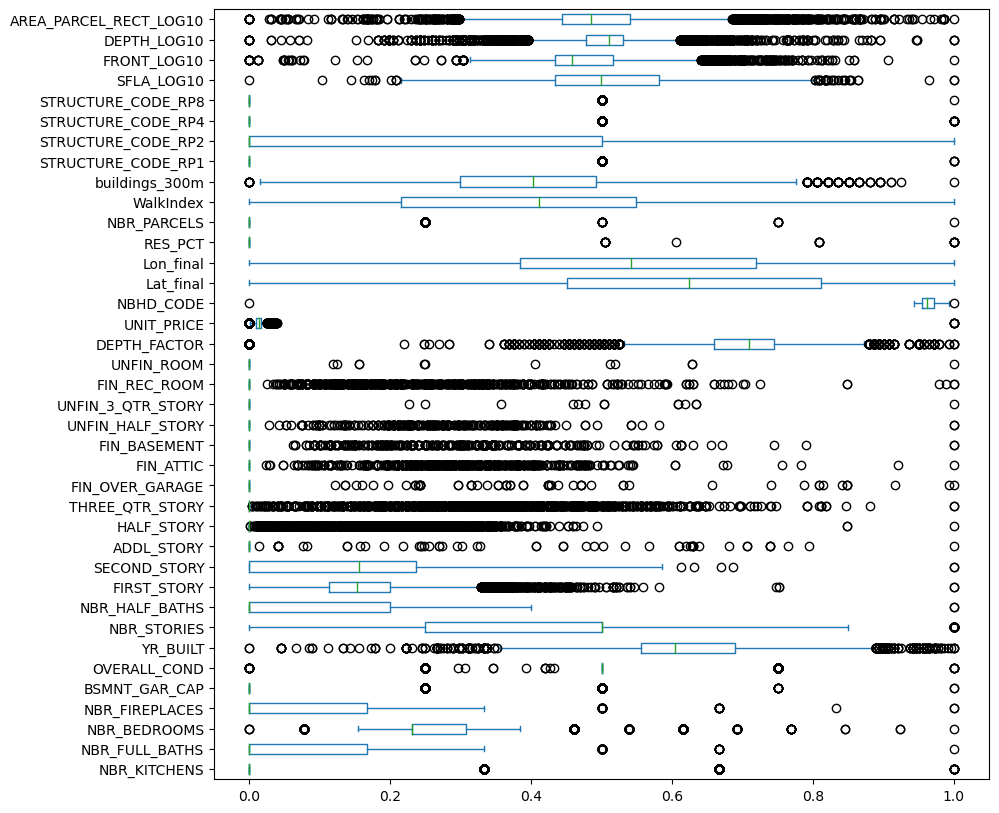

In [38]:
# careful as we are normalizing the training and test data
X, y, df_scaled = imputer(df0) # let's use this to visualize the major features
df_scaled.plot.box(vert=False,figsize=(10,10)) # visualization

NBR_FULL_BATHS
Skew : 1.24


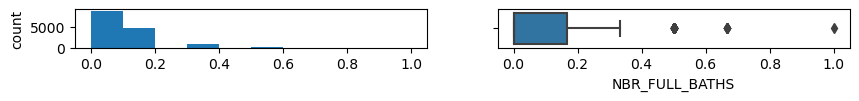

NBR_BEDROOMS
Skew : 1.37


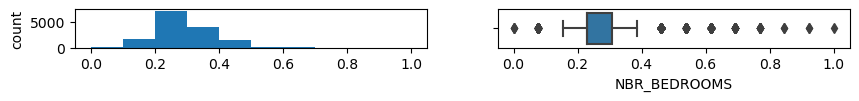

NBR_FIREPLACES
Skew : 1.11


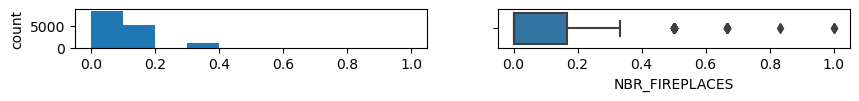

BSMNT_GAR_CAP
Skew : 3.75


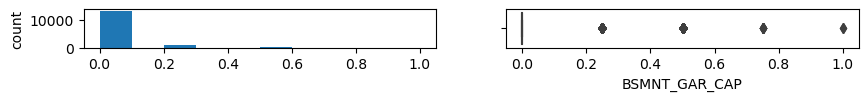

OVERALL_COND
Skew : -0.68


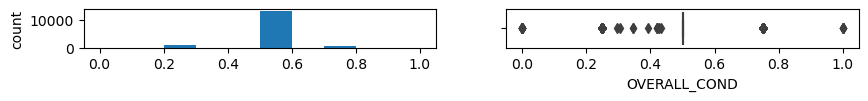

YR_BUILT
Skew : -0.09


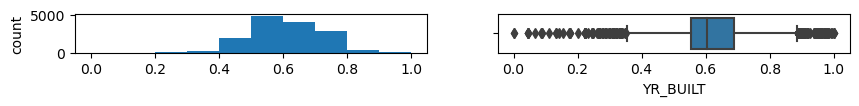

NBR_STORIES
Skew : -0.61


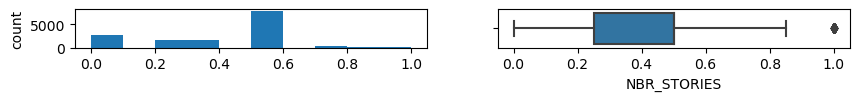

NBR_HALF_BATHS
Skew : 1.0


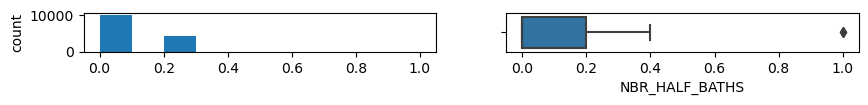

FIRST_STORY
Skew : 1.53


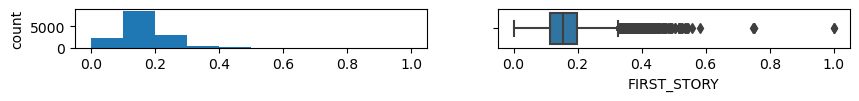

SECOND_STORY
Skew : 0.36


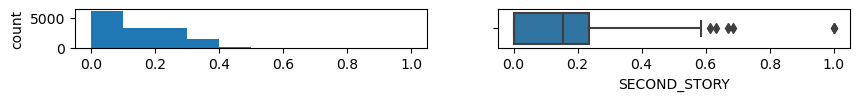

ADDL_STORY
Skew : 22.13


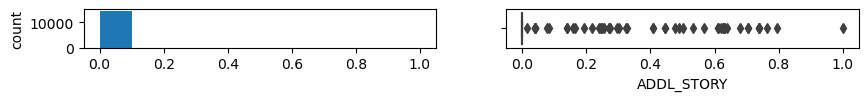

HALF_STORY
Skew : 2.49


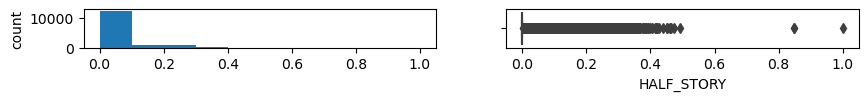

THREE_QTR_STORY
Skew : 2.84


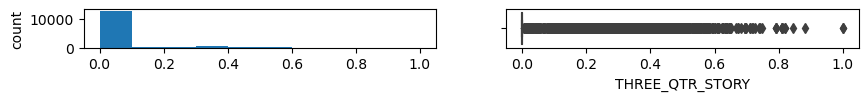

FIN_OVER_GARAGE
Skew : 21.26


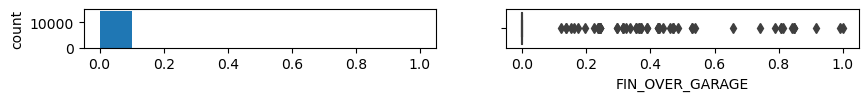

FIN_ATTIC
Skew : 5.48


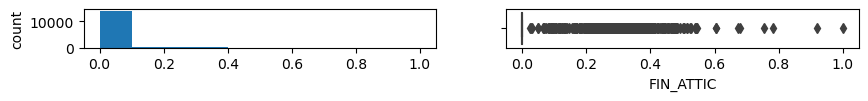

FIN_BASEMENT
Skew : 8.44


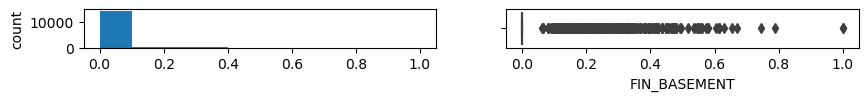

UNFIN_HALF_STORY
Skew : 8.8


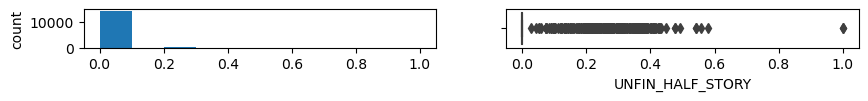

UNFIN_3_QTR_STORY
Skew : 37.75


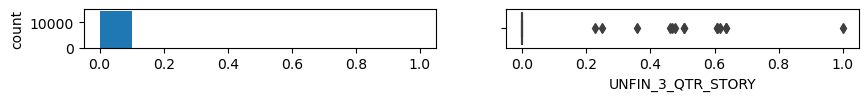

FIN_REC_ROOM
Skew : 6.36


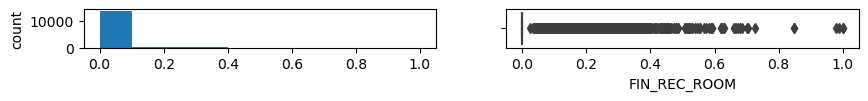

UNFIN_ROOM
Skew : 51.26


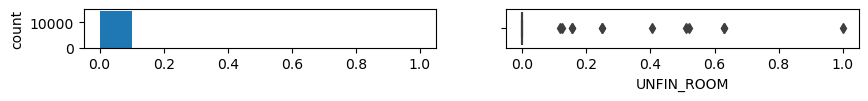

DEPTH_FACTOR
Skew : -2.25


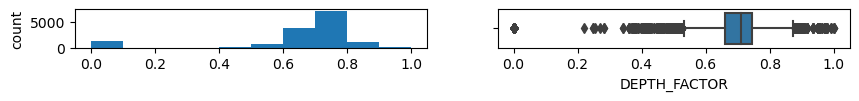

UNIT_PRICE
Skew : 42.42


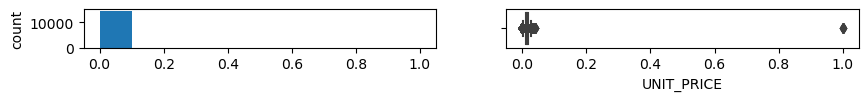

NBHD_CODE
Skew : -28.54


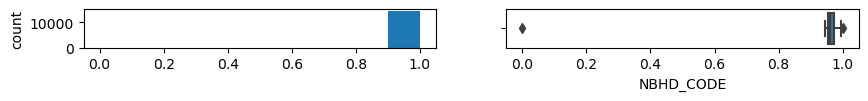

Lat_final
Skew : -0.51


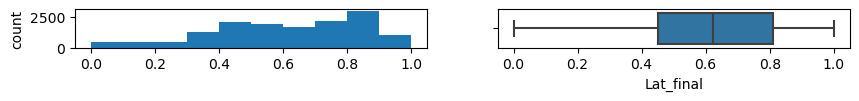

Lon_final
Skew : -0.32


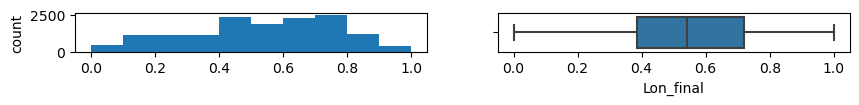

RES_PCT
Skew : 28.98


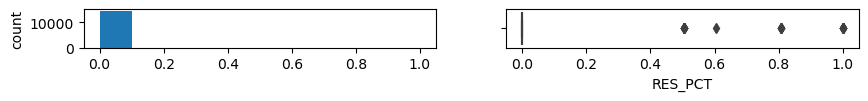

NBR_PARCELS
Skew : 13.6


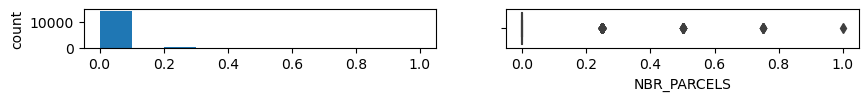

WalkIndex
Skew : 0.33


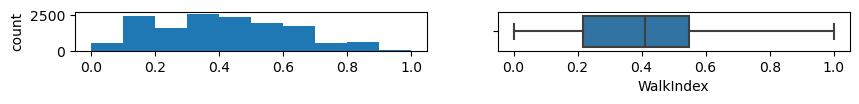

buildings_300m
Skew : 0.24


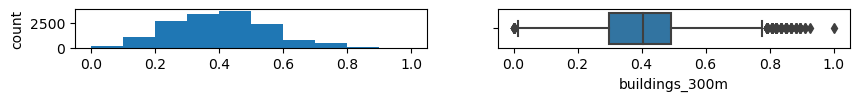

STRUCTURE_CODE_RP1
Skew : 2.56


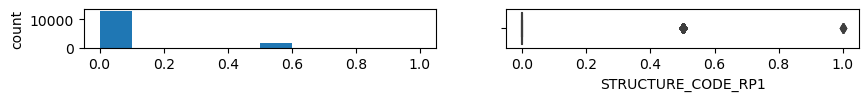

STRUCTURE_CODE_RP2
Skew : 1.16


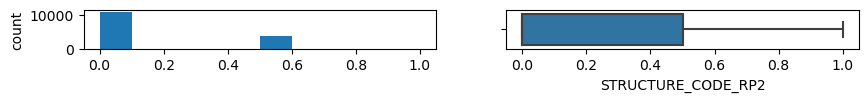

STRUCTURE_CODE_RP4
Skew : 1.26


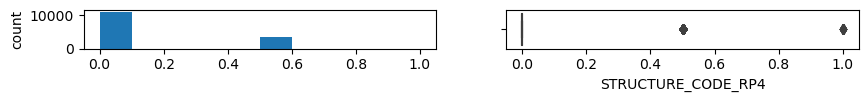

STRUCTURE_CODE_RP8
Skew : 3.87


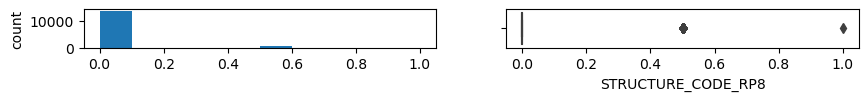

SFLA_LOG10
Skew : 0.17


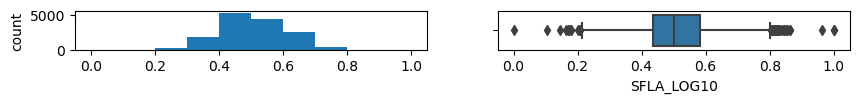

FRONT_LOG10
Skew : 0.51


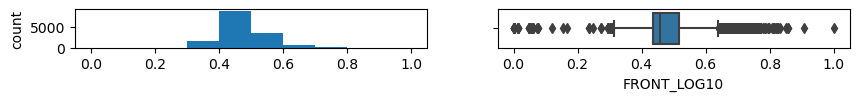

DEPTH_LOG10
Skew : -0.43


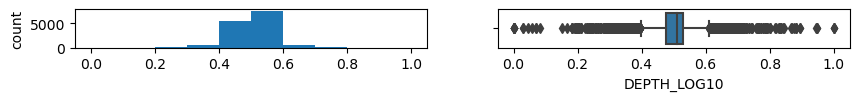

AREA_PARCEL_RECT_LOG10
Skew : 0.4


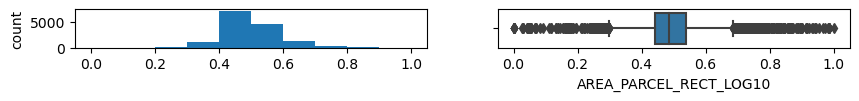

In [39]:
def show_dist(data):
    for col in data.columns[1:]:
        print(col)

        print('Skew :', round(data[col].skew(), 2))

        plt.figure(figsize = (10, 0.5))
        plt.subplot(1, 2, 1)
        data[col].hist(bins = 10, grid = False)

        plt.ylabel('count')
        plt.subplot(1, 2, 2)
        sns.boxplot(x = data[col])
        plt.show()
        
show_dist(df_scaled)

In [40]:
#report_missing(df0)

# **Split Data**

In [41]:
from sklearn.model_selection import train_test_split

X, y = prepare(df0)
# again we are splitting our data after normalization... not the best practice!
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #, random_state=42)

# **Check Dataset**

In [42]:
# Model / data parameters
#num_classes = 2
SIZE = x_train.shape[1]
input_shape = (SIZE, 1)

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

print("y_train shape:", y_train.shape)

x_train shape: (11568, 138)
11568 train samples
2893 test samples
y_train shape: (11568,)


In [43]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(x_train))

2023-05-17 14:08:50.011937: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-17 14:08:50.011993: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tesla): /proc/driver/nvidia/version does not exist
2023-05-17 14:08:50.012763: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [44]:
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# **NN Model**

We want to be able to understand nonlinear features that might be the result of inspections bias.  An Autoencoder Neural Network will be used for our regression model to aid our exploration of these features.

See section 4.3 of Deep Learning with Python

In [45]:
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Dense, Flatten, 
                                     Dropout, ReLU, LeakyReLU, BatchNormalization)
import tensorflow.keras as keras
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential
import gc

LATENT_SIZE = 6
tf.keras.backend.clear_session() # clean up backend

model = tf.keras.Sequential([
    normalizer,
    layers.Dense(SIZE, activation="relu", input_shape = input_shape),
    Dropout(0.2),
    #BatchNormalization(),
    layers.Dense(SIZE*2, activation="relu"),
    Dropout(0.2),
    BatchNormalization(),
    layers.Dense(SIZE/8, activation="relu"),
    Dropout(0.2),
    BatchNormalization(),
    layers.Dense(SIZE, activation="relu"),
    Dropout(0.4),
    #BatchNormalization(),
    layers.Dense(units=1) ])
'''
inputs = keras.Input(shape = input_shape)
x = layers.Dense(SIZE, activation="relu")(inputs)
residual = x
x = Dropout(0.2)(x)
residual = layers.Dense(SIZE, activation="relu")(residual)
x = layers.add([x,residual])

x = layers.Dense(SIZE*2, activation="relu")(x)
residual = x
x = Dropout(0.2)(x)
residual = layers.Dense(SIZE*2, activation="relu")(residual)
x = layers.add([x,residual])

x = layers.Dense(SIZE/8, activation="relu")(x)
residual = x
x = Dropout(0.2)(x)
residual = layers.Dense(SIZE/8, activation="relu")(residual)
x = layers.add([x,residual])

x = layers.Dense(SIZE, activation="relu")(x)

outputs = layers.Dense(1, activation="relu")(x)

model = keras.Model(inputs=inputs, outputs=outputs) 
#FIX ME if time... this model is promising!
'''

model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 138)              277       
 n)                                                              
                                                                 
 dense (Dense)               (None, 138)               19182     
                                                                 
 dropout (Dropout)           (None, 138)               0         
                                                                 
 dense_1 (Dense)             (None, 276)               38364     
                                                                 
 dropout_1 (Dropout)         (None, 276)               0         
                                                                 
 batch_normalization (BatchN  (None, 276)              1104      
 ormalization)                                          

In [ ]:
#model.compile(optimizer="Adam", loss="mean_squared_error", metrics=["mae"])

batch_size = 128
epochs = 150

model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mae"])
model.summary()
history= model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 138)              277       
 n)                                                              
                                                                 
 dense (Dense)               (None, 138)               19182     
                                                                 
 dropout (Dropout)           (None, 138)               0         
                                                                 
 dense_1 (Dense)             (None, 276)               38364     
                                                                 
 dropout_1 (Dropout)         (None, 276)               0         
                                                                 
 batch_normalization (BatchN  (None, 276)              1104      
 ormalization)                                          

# **Training History**

mean absolute error (MAE) is a measure of errors between paired observations expressing the same phenomenon.

$mae= \sum^n_{i=1} \frac{|y_i-\hat{y}_i|}{n}$

$\text{mae=mean absolute error}$

$y_i=\text{prediction}$

$\hat{y_i}=\text{true value}$

$\text{n=total number of data points}$

In [ ]:
def plot_accuracy(history):

    N = len(history['mae'])
    plt.figure(figsize = (7, 7))
    plt.plot(np.arange(0, N), np.array(history['mae']), label = "loss [mae]", ls = '--')
    plt.plot(np.arange(0, N), np.array(history["loss"]), label = "val_loss", ls = '--')
    plt.title("Error vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Error [SALES_PRICE_LOG10]")
    plt.legend(loc="upper left")

In [ ]:
plot_accuracy(history.history)

# **Make Prediction**

Note we have some wildly small predictions (zero) and a few large outliner.  We ought to look into these.

In [ ]:
test_mse_score, test_mae_score = model.evaluate(x_test, y_test)
#df_p = pd.merge(df0_)
#X, a, df_b = imputer(df_p, prediction = True)

In [ ]:
test_mae_score

In [ ]:
#y = model.predict(X) 
predictions = model.predict(x_test)

In [ ]:
sorted_index = np.argsort(y_test)

yy = []
y_hat = []
mv = []
for i,si in enumerate(sorted_index):
  yy.append(y_test[si])
  y_hat.append(predictions[si])

plt.ylim(y_test.min(),y_test.max())

plt.title('Predicted Sale Price [Log]')
plt.xlabel('Index [Ordered by Actual Sales Price]')
plt.ylabel('Sale Price [Log]')

plt.plot(np.array(y_hat),c= 'orange', label='Predicted')
plt.plot(np.array(yy), c= 'blue', label='Actual')
plt.legend();

In [ ]:
plt.title('Predicted Sale Price')
plt.xlabel('Index [Ordered by Actual Sales Price]')
plt.ylabel('Sale Price [Linear]')

plt.plot(10**np.array(y_hat),c= 'orange', label='Predicted')
plt.plot(10**np.array(yy), c= 'blue', label='Actual')
plt.legend();

# our model is predicting zero vaules thus overflow in power

# **Observations: Sale Prediction**

Our model is provides a good prediction for the sales price however we can see a number of properties being undervalued and overvalued.  Overfitting this model can lead to vanishing gradient descent resulting it zero value predictions. A pass thru was to be added to the model to develop a VAE Model, however while this model type may cover up the nonlinear bias features we are attempting to extract. 

# **Part 1, Paragraph 2: Assess Inspections**

Above in the section 'Correlate an Index' we discovered a method to index the two dataset to 98.7%.  We shall now use these indices to compare the actual-sale-price, predicted-sale-price, and assessment-price together.

We've made no direct attempt to scale predicted-sale-price in time which might have been an interesting avenue.  Our AE NN model ought to predict for this once we add a linear time factor.  FIX ME!!! Convert SALE_DATE to unix time for model training.

In [ ]:
# Recall our correlated indices...
my_index = df['index'].to_list()
my_index = df1.loc[df1['index'].isin(my_index)]['index'].to_list()
len(my_index)

In [ ]:
len(my_index)/len(df1) # assessment record yields

In [ ]:
df[['SALE_PRICE_LOG10', 'index']].head()
len(df.loc[df['index'].isin(my_index)])

In [ ]:
df0_ = df.loc[df['index'].isin(my_index)]
df1_ = df1.loc[df1['index'].isin(my_index)]

In [ ]:
len(df0_), len(df1_), len(df0_.columns)

In [ ]:
df_new = clean_df(df0_)

In [ ]:
X, y = prepare(df_new)
X = np.expand_dims(X, -1)

In [ ]:
#print(x_test.shape, X.shape)
y_hat = model.predict(X) 

In [ ]:
len(y), len(y_hat)

In [ ]:
y_assess = df1_['MARKET_VAL'].apply(np.log10).to_numpy()
y_assess

In [ ]:
# plot a comparison
sorted_index = np.argsort(y) # sort by actual

yy = []
yy_hat = []
yy_assess = []
for i,si in enumerate(sorted_index):
  yy.append(y[si])
  yy_hat.append(y_hat[si])
  yy_assess.append(y_assess[si])

plt.ylim(y.min(),y.max())

plt.title('Predicted Sale Price [Log]')
plt.xlabel('Index [Ordered by Actual Sales Price]')
plt.ylabel('Sale Price [Log]')

plt.plot(np.array(yy_hat),c= 'orange', label='Predicted')
plt.plot(np.array(yy), c= 'blue', label='Actual')
plt.plot(np.array(yy_assess), c= 'red', label='Market Val',alpha=0.2)
plt.legend();

In [ ]:
# Calculate the difference between assessment value and sale price
df1['MARKET_VAL_DIFF'] = df1['MARKET_VAL'] - df1['SALE_PRICE']

# Create a scatter plot
#plt.scatter(df_assessment_sales['SALE_PRICE'], df_assessment_sales['MARKET_VAL_DIFF'])
sns.scatterplot(data=df1, 
                x='SALE_PRICE', 
                y='MARKET_VAL_DIFF')

# Set axis labels
plt.xlabel('Sale Price')
plt.ylabel('Assessment - Sale Price Difference')

# Show the plot
plt.show()

# **Observations** 

This will create a scatter plot with sale prices on the x-axis and the difference between assessment value and sale price on the y-axis. The plot can help us visualize any potential equity issues with the assessment process.

If the points are scattered around the zero difference line, then it would suggest that the assessment process is generally fair and accurate. However, if there is a trend where certain groups of properties consistently have lower or higher assessment values compared to their sale prices, then it could suggest potential equity issues.

It's important to note that this graph alone cannot provide definitive evidence of equity issues. Further analysis and investigation would be necessary to confirm any potential biases in the assessment process.

# **Appendix 0. Notes and Stuff**